In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

In [2]:
# Load the preprocessed dataset
file_path = "../data/preprocessed_breast_cancer_data.csv"  # Update path if necessary
data = pd.read_csv(file_path)

In [3]:
# Display basic info and check for any remaining missing values
print("Dataset Shape:", data.shape)
print("Missing Values:")
print(data.isnull().sum())

Dataset Shape: (2509, 34)
Missing Values:
patient_id                        0
age_at_diagnosis                  0
type_of_breast_surgery            0
cancer_type                       0
cancer_type_detailed              0
cellularity                       0
chemotherapy                      0
pam50_+_claudin-low_subtype       0
cohort                            0
er_status_measured_by_ihc         0
er_status                         0
neoplasm_histologic_grade         0
her2_status_measured_by_snp6      0
her2_status                       0
tumor_other_histologic_subtype    0
hormone_therapy                   0
inferred_menopausal_state         0
integrative_cluster               0
primary_tumor_laterality          0
lymph_nodes_examined_positive     0
mutation_count                    0
nottingham_prognostic_index       0
oncotree_code                     0
overall_survival_(months)         0
overall_survival_status           0
pr_status                         0
radio_therapy         

In [4]:
# Initialize figure settings for better visualization
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

### Kaplan-Meier Survival Analysis

The Kaplan-Meier Survival Curve helps visualize the probability of survival over time for different groups.

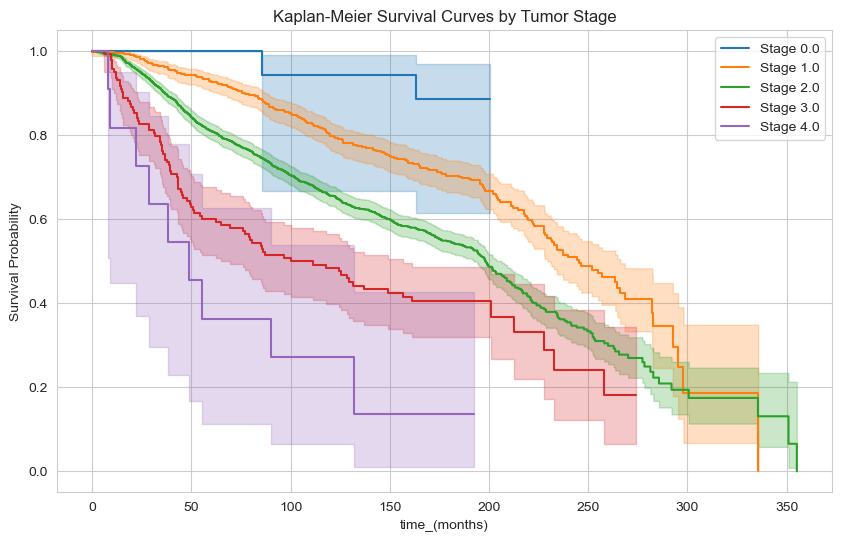

In [5]:
kmf = KaplanMeierFitter()
plt.figure()
for stage in sorted(data['tumor_stage'].unique()):
    stage_data = data[data['tumor_stage'] == stage]
    kmf.fit(stage_data['overall_survival_(months)'], event_observed=stage_data["vital_status"])
    kmf.plot(label=f'Stage {stage}')
plt.title("Kaplan-Meier Survival Curves by Tumor Stage")
plt.xlabel("time_(months)")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()

**Observations**
1. **Stage 0 and 1 have the highest survival probabilities over time**, indicating early detection leads to better survival outcomes.
2. **Stage 3 and 4 show a significant drop**, suggesting that survival chances decrease as the tumor progresses to later stages.
3. **Stage 2 appears to have an intermediate survival curve**, but with a slower decline compared to Stages 3 and 4.
4. **Stage 4 patients have the steepest drop-off**, highlighting the aggressive nature of late-stage cancer.

### Log-Rank Test

The Log-Rank Test is a statistical test used to compare survival distributions between different groups—in this case, **Tumor Stage 1 vs. Tumor Stage 2**.

In [6]:
# Perform Log-Rank Test for multiple tumor stage comparisons
stage_pairs = [(1, 2), (2, 3), (3, 4)]

for stage_A, stage_B in stage_pairs:
    stage_A_data = data[data['tumor_stage'] == stage_A]['overall_survival_(months)']
    stage_B_data = data[data['tumor_stage'] == stage_B]['overall_survival_(months)']
    event_A = data[data['tumor_stage'] == stage_A]["vital_status"]
    event_B = data[data['tumor_stage'] == stage_B]["vital_status"]
    
    logrank_result = logrank_test(stage_A_data, stage_B_data, event_observed_A=event_A, event_observed_B=event_B)
    
    print(f"Log-Rank Test between Stage {stage_A} and Stage {stage_B}: p-value = {logrank_result.p_value:.5g}")

Log-Rank Test between Stage 1 and Stage 2: p-value = 4.8076e-13
Log-Rank Test between Stage 2 and Stage 3: p-value = 5.6197e-06
Log-Rank Test between Stage 3 and Stage 4: p-value = 0.066291


**Observations**
1. **Stage 1 vs. Stage 2**:
    - p-value=4.8076e-13 (very significant difference)
    - There is a **highly significant difference** in survival between Stage 1 and Stage 2

2. **Stage 2 vs. Stage 3**:
    - p-value=5.6197e-06 (highly significant)
    - This indicates that survival distributions **differ significantly** between Stage 2 and Stage 3.

3. **Stage 3 vs. Stage 4**:
    - p-value=0.066291 (not statistically significant at p<0.05)
    - This suggests **no significant difference** in survival between Stage 3 and Stage 4

### Cox Proportional Hazards Model

To perform survival analysis, two critical columns need to be defined:
   - `overall_survival_(months)`: Represents the time from diagnosis until death or last follow-up.
   - `overall_survival_status`: The event indicator, where `1` indicates the event (death) occurred and `0` indicates right-censored data (patient is still alive or lost to follow-up)

In [7]:
# define survival time and event columns
survival_time_col = 'overall_survival_(months)'
censoring_col = 'overall_survival_status'

In [13]:
# select relevant covariates
selected_features = ['age_at_diagnosis', 'tumor_size', 'lymph_nodes_examined_positive', 'er_status', 
                     'pr_status', 'her2_status']

cph_data = data[[survival_time_col, censoring_col] + selected_features].dropna()

#### Fitting the Cox Proportional Hazards Model

The CoxPHFitter is used to estimate the hazard ratios for the selected covariates.

In [14]:
# fit the Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(cph_data, duration_col=survival_time_col, event_col=censoring_col)

<lifelines.CoxPHFitter: fitted with 2509 total observations, 837 right-censored observations>

Ater fitting the mode, the output confirms:
   - **Total observations**: 2509 patients
   - **Right-censored observations**: 837 patients (patients still alive or lost to follow-up)

This model hekps identify **statistically significant predictors of survival and provides hazard ratios**, which qualify how much each factor increases or decreases the risk of death.

#### Cox Proportional Hazards Model Summary

In [15]:
# summary of the Cox model
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 2509 total observations, 837 right-censored observations>
             duration col = 'overall_survival_(months)'
                event col = 'overall_survival_status'
      baseline estimation = breslow
   number of observations = 2509
number of events observed = 1672
   partial log-likelihood = -11510.70
         time fit was run = 2025-01-31 16:35:29 UTC

---
                               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                      
age_at_diagnosis               0.03      1.03      0.00            0.02            0.03                1.02                1.03
tumor_size                     0.01      1.01      0.00            0.00            0.01                1.00                1.01
lymph_nodes_examined_positive  0.05      1.05      0.01            0.04            0.06                1.04                1.07
er_status                     -0.20      0.82      0.06           -0.32           -0.08                0.72                0.93
pr_status                     -0.03      0.97      0.06           -0.14            0.09                0.87                1.09
her2_status                    0.33      1.39      0.09            0.16            0.51                1.17                1.66

                               cmp to     z      p  -log2(p)
covariate                                                   
age_at_diagnosis                 0.00 12.72 <0.005    120.75
tumor_size                       0.00  5.30 <0.005     23.03
lymph_nodes_examined_positive    0.00  9.90 <0.005     74.33
er_status                        0.00 -3.20 <0.005      9.51
pr_status                        0.00 -0.44   0.66      0.60
her2_status                      0.00  3.69 <0.005     12.14
---
Concordance = 0.66
Partial AIC = 23033.40
log-likelihood ratio test = 334.45 on 6 df
-log2(p) of ll-ratio test = 227.47

#### Insights from the model
1. **Older patients have a higher risk of death** (HR = 1.03, p < 0.005).
2. **Tumor size and lymph node involvement are significant predictors of survival.**
3. **Estrogen receptor (ER) positive status is associated with lower mortality risk.**
4. **HER2-positive status significantly increases the hazard of death** (HR = 1.39).
5. **Progesterone receptor (PR) status does not significantly impact survival** (p = 0.66).

The **Concordance Index (C = 0.66)** indicates moderate predictive accuracy of the model.

#### Hazard Ratio Plot for Cox Proportional Hazards Model

The plot visualizes the **log(Hazard Ratios) (HR) and 95% Confidence Intervals (CI)** for each covariate in the Cox model.

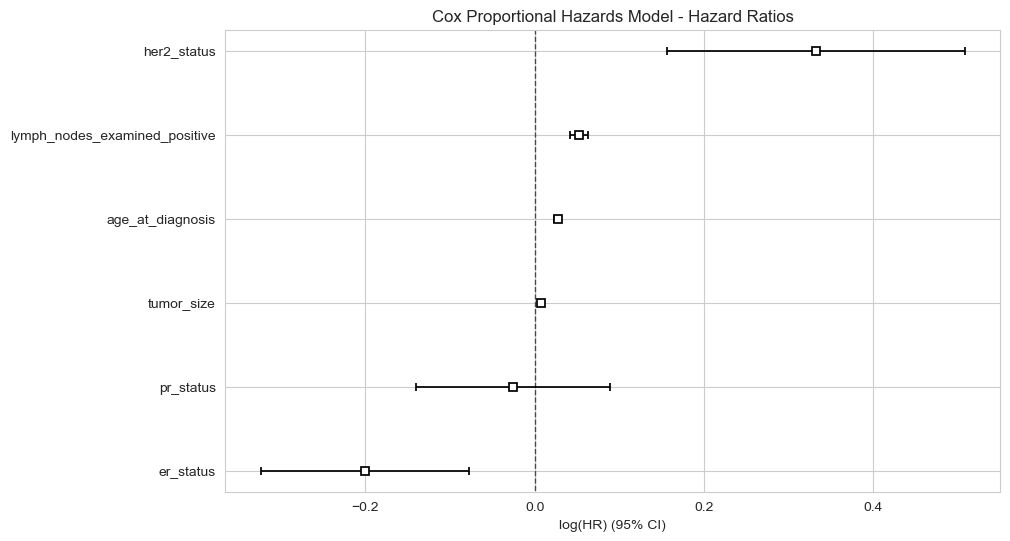

In [16]:
# plot hazard ratios
cph.plot()
plt.title("Cox Proportional Hazards Model - Hazard Ratios")
plt.show()

#### Interpretation of the Plot
- The x-axis represents log(HR), where:
    - Positive values (>0) indicate higher risk of death.
    - Negative values (<0) indicate lower risk of death.
    - The dashed vertical line at 0 represents a neutral effect (HR = 1).
- Each square represents the hazard ratio, with the horizontal lines showing the 95% confidence interval (CI).

#### Key Findings
1. **HER2 Status**:
    - HER2-positive patients have a significantly increased risk of death (log(HR) > 0).
    - The wide confidence interval suggests some variability in effect size.
    
2. **Lymph Nodes Examined Positive**:
    - More positive lymph nodes increase hazard risk, indicating poorer prognosis.

3. **Age at Diagnosis**:
    - Older age is associated with slightly higher mortality risk, but the effect is smaller than other variables.

4. **Tumor Size**:
    - Larger tumor size slightly increases the hazard but has a narrow confidence interval, indicating consistent results.

5. **ER Status**:
    - ER-positive patients have a lower hazard risk (log(HR) < 0), meaning they are more likely to survive longer.

6. **PR Status**:
    - PR status does not show a significant impact on survival, as the confidence interval crosses zero.

#### Insights
- HER2-positive and lymph node involvement are strong risk factors for mortality.
- ER-positive patients have a survival advantage.
- PR status does not have a significant impact on survival in this dataset.